# **meta data**

,Feature,Type,Unique Values
0,Country,string,10
1,Year,int64,10
2,Attack Type,string,6
3,Target Industry,string,7
4,Financial Loss (in Million $),float64,2536
5,Number of Affected Users,int64,2998
6,Attack Source,string,4
7,Security Vulnerability Type,string,4
8,Defense Mechanism Used,string,5
9,Incident Resolution Time (in Hours),int64,72


Column 'Year' has values below zero: False
Column 'Financial Loss (in Million $)' has values below zero: False
Column 'Number of Affected Users' has values below zero: False
Column 'Incident Resolution Time (in Hours)' has values below zero: False


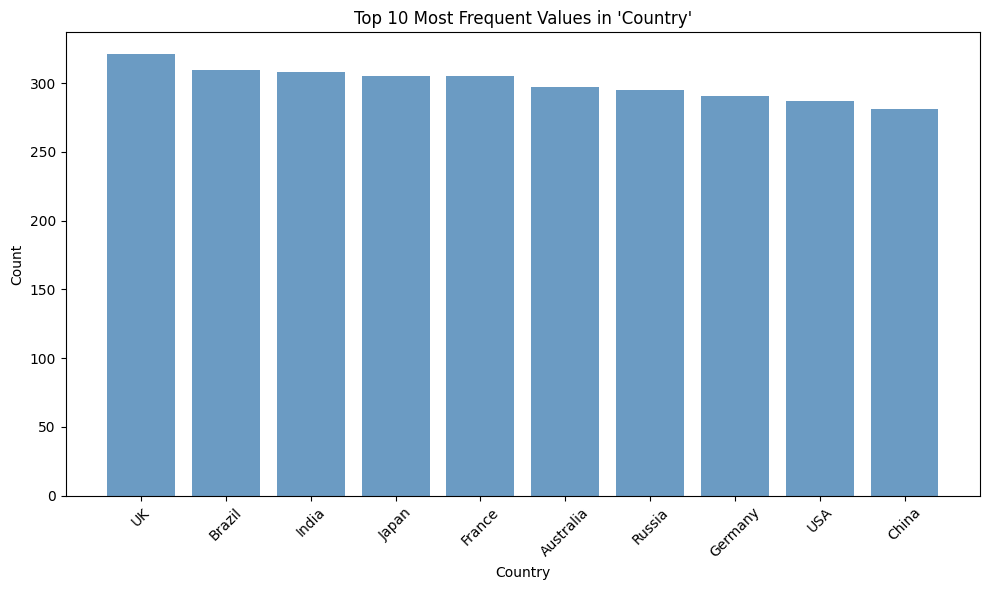

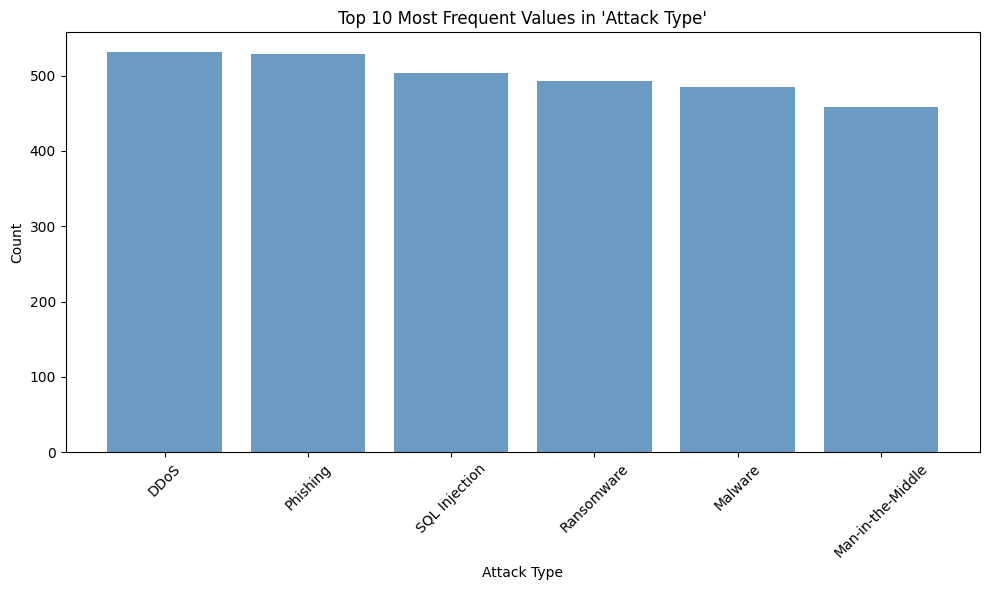

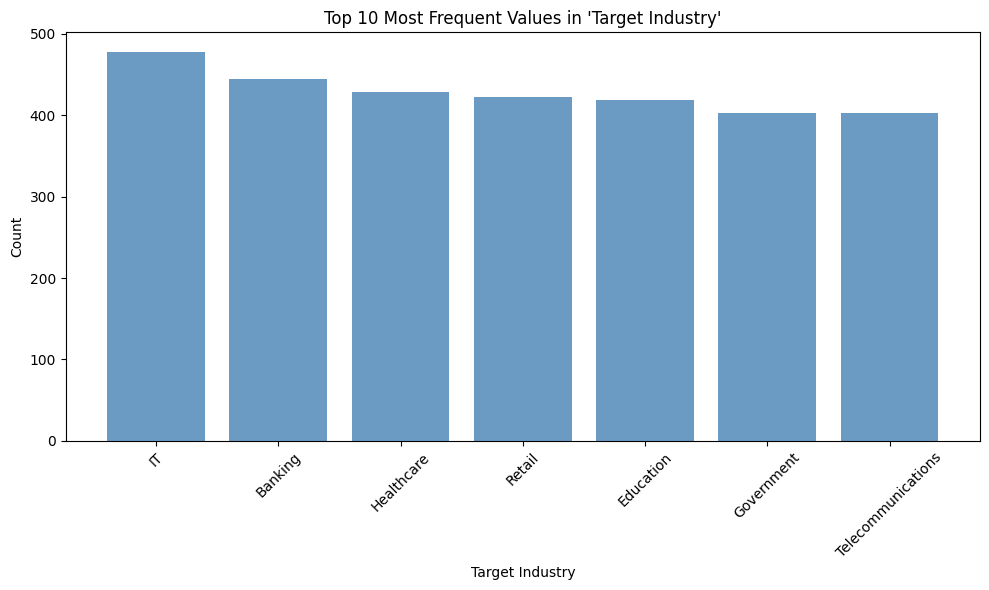

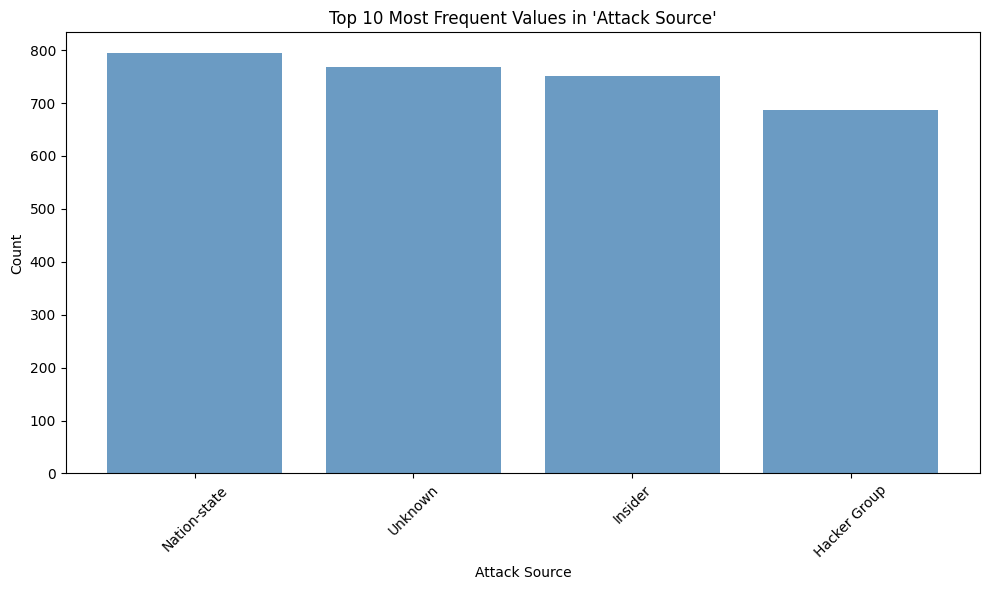

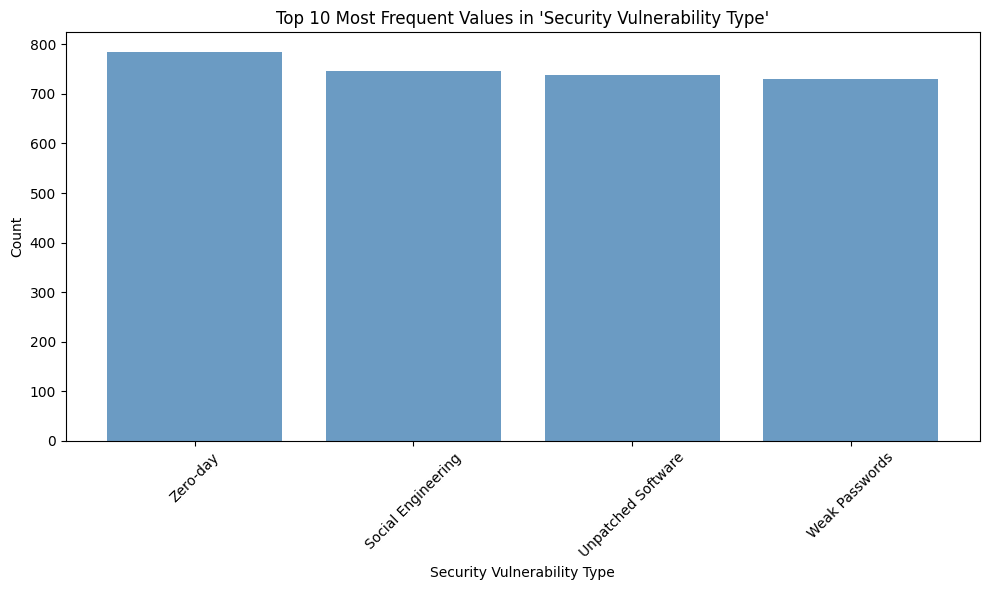

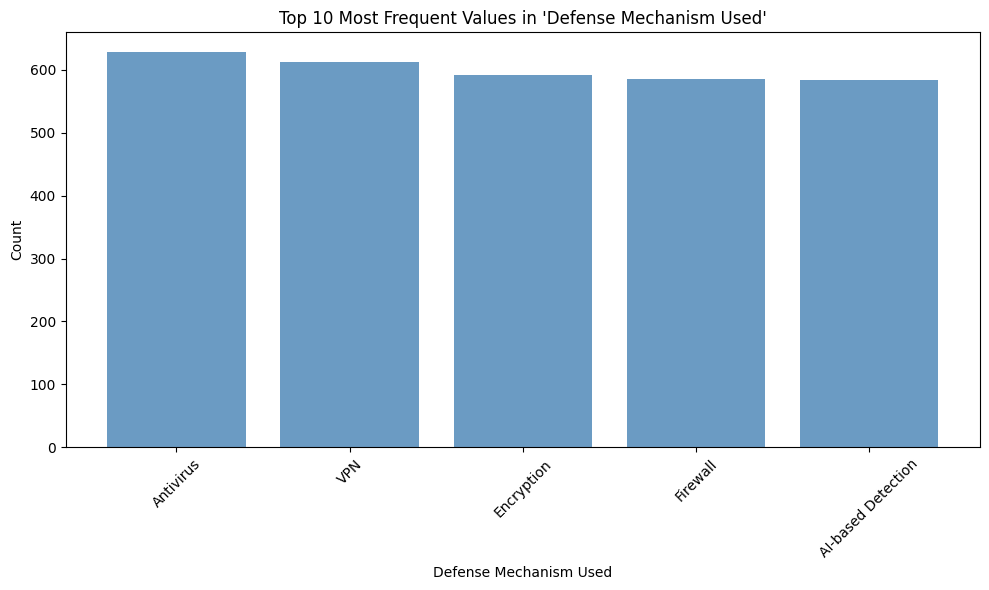

In [26]:
# %pip install pandas
# %pip install ace_tools
# %pip install matplotlib
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'data.csv' with your file path
df = pd.read_csv('Global_Cybersecurity_Threats_2015-2024.csv')

# Dictionary to hold value counts for each column
unique_values_summary = {}

summary = pd.DataFrame({
    "Feature": df.columns,
    "Type": [("string" if df[col].dtype == "object" else df[col].dtype.name) for col in df.columns],
    "Unique Values": [df[col].nunique(dropna=False) for col in df.columns]
})

# Display the result
display(summary.style.set_properties(**{'text-align': 'left'}))

# Assuming your DataFrame is named df
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    has_below_zero = (df[col] < 0).any()
    print(f"Column '{col}' has values below zero: {has_below_zero}")

textual_features = df.select_dtypes(include=['object']).columns.tolist()

# Plotting the top 10 most frequent values for each textual feature
for col in textual_features:
    value_counts = df[col].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    plt.bar(value_counts.index.astype(str), value_counts.values, color='steelblue', alpha=0.8)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Top 10 Most Frequent Values in '{col}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

as we can see in the numerical features all of the data is correct (there are no negative values and the years are from 2015-2024).
but with textual features we can clearly see that in the 'attack source' feature there is an "unknown" value. i wont remove the value (yet) because it might be usefull for the future.

# **Statistics**

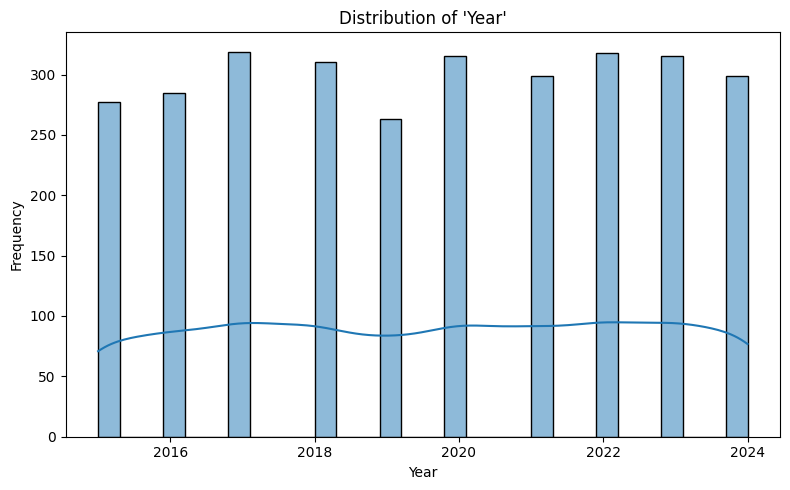

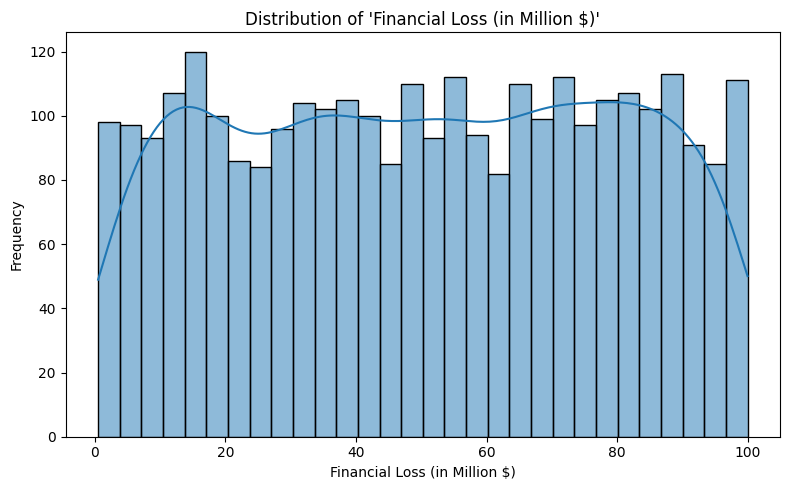

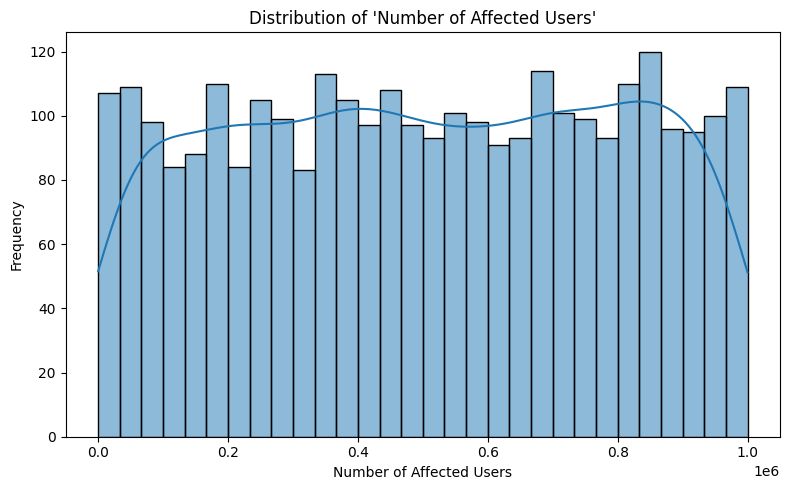

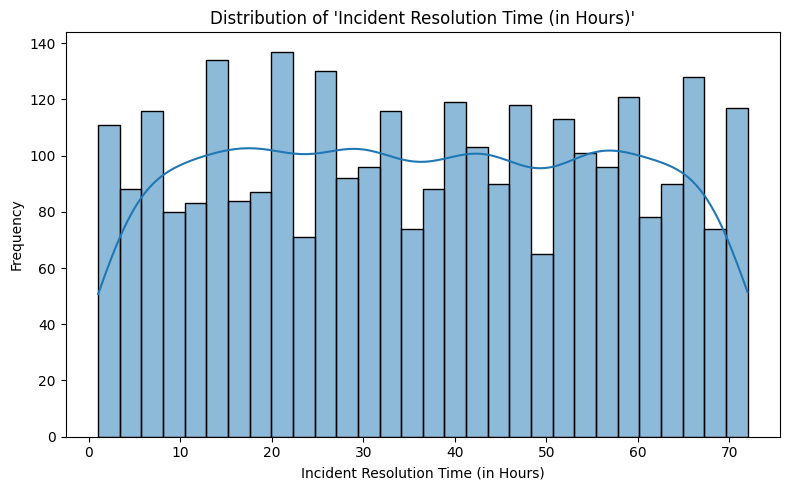


--- Central Tendencies for Numeric Features ---


,Mean,Median,Mode,Min,Max,Standard Deviation
Year,2019.570333,2020.000000,2017.000000,2015.000000,2024.000000,2.857932
Financial Loss (in Million $),50.492970,50.795000,17.990000,0.500000,99.990000,28.791415
Number of Affected Users,504684.136333,504513.000000,164890.000000,424.000000,999635.000000,289944.084972
Incident Resolution Time (in Hours),36.476000,37.000000,43.000000,1.000000,72.000000,20.570768


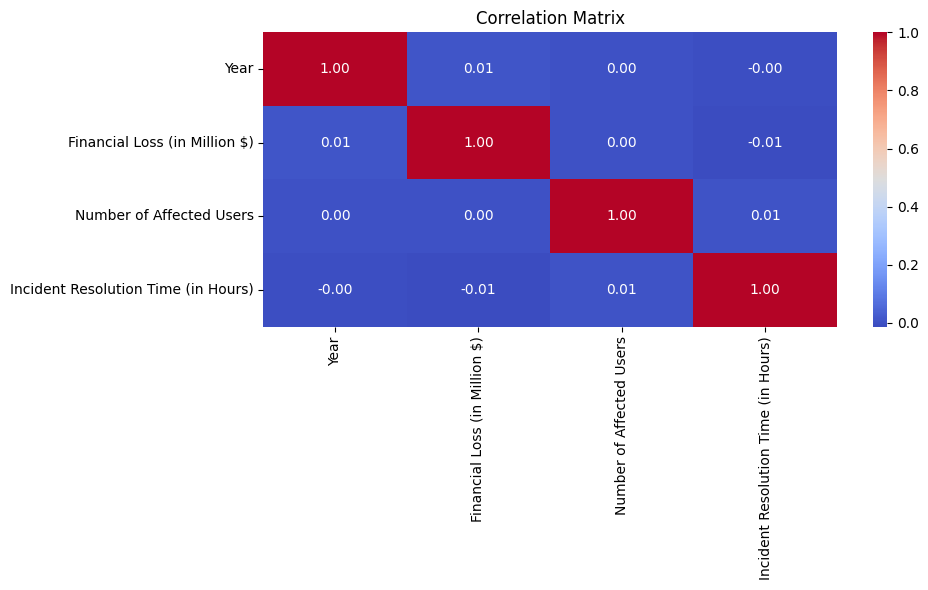

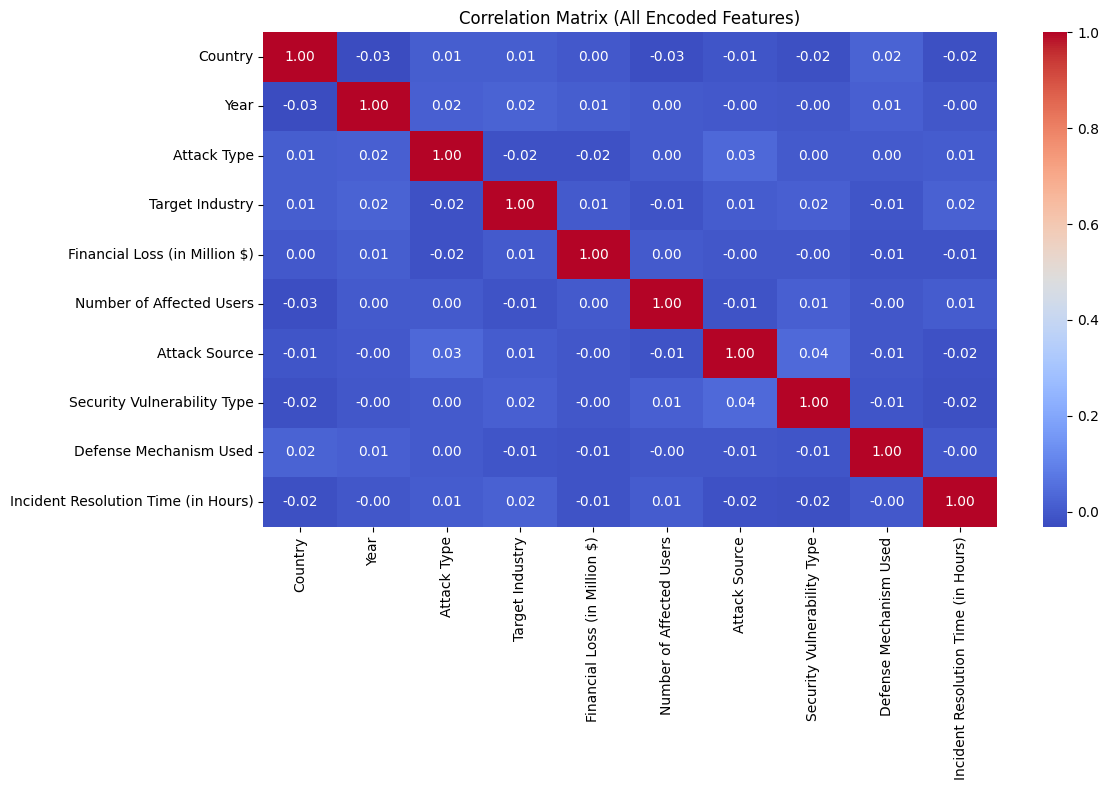

In [27]:
# %pip install seaborn
# %pip install scikit-learn
# %pip install jinja2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


# 2. Distribution plots for numeric features
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3. Calculate central tendencies
central_tendencies = pd.DataFrame({
    "Mean": df[numeric_cols].mean(),
    "Median": df[numeric_cols].median(),
    "Mode": df[numeric_cols].mode().iloc[0],
    "Min": df[numeric_cols].min(),
    "Max": df[numeric_cols].max(),
    "Standard Deviation": df[numeric_cols].std(),
})

print("\n--- Central Tendencies for Numeric Features ---")
display(central_tendencies.style.set_properties(**{'text-align': 'left'}))

# 4. Correlation matrix
plt.figure(figsize=(10, 6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()



encoded_df = df.copy()

# Label encode all object (textual) columns
label_encoders = {}
for col in encoded_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    label_encoders[col] = le

# Compute the full correlation matrix
correlation_matrix = encoded_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (All Encoded Features)")
plt.tight_layout()
plt.show()

we can see that dimension reduction wont work because the correlation between the features is 0. <br>
i put 2 types of correlations, one where i encoded the textual features, and the other i kept to see the correaltion between the numeric features better.
<br><br>
we have 3000 samples, and as we can see from the uniqueness of the features all of them have duplicates except the feature 'Number of Affected Users' which has 2998 unique values.

# **Abnormality detection**

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# -----------------------------------------------------------
# 0. LOAD DATA
# -----------------------------------------------------------
df = pd.read_csv("Global_Cybersecurity_Threats_2015-2024.csv")

num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

# -----------------------------------------------------------
# 1. UNIVARIATE NUMERIC OUTLIERS  (Z-score rule)
# -----------------------------------------------------------
for col in num_cols:
    z = (df[col] - df[col].mean()) / df[col].std(ddof=0)
    df[f"{col}_z_outlier"] = z.abs() > 3          # True ⇢ outlier

print("\n--- Z-Score Outliers per Numeric Feature ---")
for col in num_cols:
    print(f"{col}: {df[f'{col}_z_outlier'].sum()}")

# -----------------------------------------------------------
# 2. UNIVARIATE CATEGORICAL “RARE-LEVEL” OUTLIERS
#    (levels whose frequency < min_freq_pct)
# -----------------------------------------------------------
min_freq_pct = 0.01          # 1 % threshold

for col in cat_cols:
    freq = df[col].value_counts(normalize=True)
    rare_levels = freq[freq < min_freq_pct].index
    df[f"{col}_rare_level"] = df[col].isin(rare_levels)

print(f"\n--- Rare-Level Outliers (< {min_freq_pct*100:.1f}% per column) ---")
for col in cat_cols:
    rare_count = df[f"{col}_rare_level"].sum()
    print(f"{col}: {rare_count} rows flagged")

# -----------------------------------------------------------
# 3. ISOLATION FOREST  (multivariate)
# -----------------------------------------------------------
df_if = df.copy()

# Label-encode categoricals
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_if[col] = le.fit_transform(df_if[col].astype(str))
    label_encoders[col] = le

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
df_if["IF_label"] = iso.fit_predict(df_if[num_cols + cat_cols])
df["IF_outlier"] = df_if["IF_label"] == -1

print(f"\nIsolation Forest detected {df['IF_outlier'].sum()} outliers.")

# -----------------------------------------------------------
# 4. LOCAL OUTLIER FACTOR  (multivariate, local)
# -----------------------------------------------------------
# Build numeric matrix (encoded cats + scaled)
df_lof = df_if[num_cols + cat_cols].copy()
X_lof = StandardScaler().fit_transform(df_lof)

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05
)
lof_labels = lof.fit_predict(X_lof)
df["LOF_outlier"] = lof_labels == -1

print(f"LOF detected {df['LOF_outlier'].sum()} outliers.")

# -----------------------------------------------------------
# 5. SAVE OR INSPECT (optional)
# -----------------------------------------------------------
df.to_csv("dataset_with_all_outlier_flags.csv", index=False)


# Find rows flagged by both methods
both_outliers = df[(df["IF_outlier"]) & (df["LOF_outlier"])]

print(f"Number of outliers flagged by BOTH IF and LOF: {both_outliers.shape[0]}")



--- Z-Score Outliers per Numeric Feature ---
Year: 0
Financial Loss (in Million $): 0
Number of Affected Users: 0
Incident Resolution Time (in Hours): 0

--- Rare-Level Outliers (< 1.0% per column) ---
Country: 0 rows flagged
Attack Type: 0 rows flagged
Target Industry: 0 rows flagged
Attack Source: 0 rows flagged
Security Vulnerability Type: 0 rows flagged
Defense Mechanism Used: 0 rows flagged

Isolation Forest detected 150 outliers.
LOF detected 150 outliers.
Number of outliers flagged by BOTH IF and LOF: 85


using univariate outliers: we didnt find any outliers even after lowering the thresholds. <br>
using multivariate outliers: using IF and LOF we found 150 outliers with each and only 85 of them are incommon (so in total 215 outliers).
<br><br>
explaintions to why this might happen:<br>
we got no univariate outliers because Each feature on its own looks normal. None of the values break the Z-score / rare-level cut-offs, so univariate tests stay silent. but multivariate outliers (IF and LOF) judge the dataset using combo of features, so a sample can look perfectly nomral on its own but when looking at everything together it might look weird.

# **Clustering**

Dropped 215 rows as outliers; 2785 rows remain for clustering.


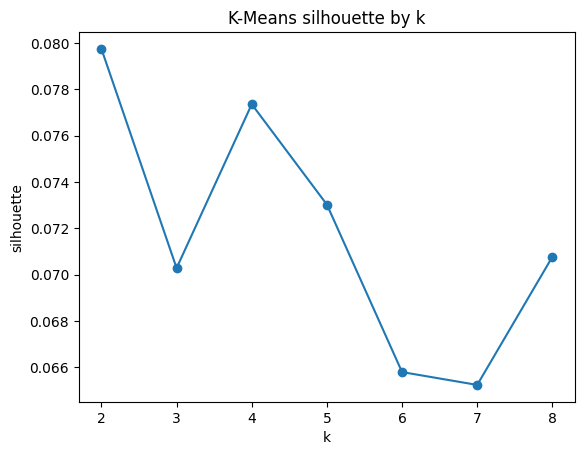

Best k = 2  (silhouette = 0.080)

Cluster sizes:
 cluster
0    1397
1    1388
Name: count, dtype: int64
Best k = 2  (silhouette = 0.080)


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ------------------------------------------------------------------
# 1) LOAD DATA (this CSV must already contain the outlier-flag columns
#    you created in Step 5).  If you still have df in memory, skip this.
# ------------------------------------------------------------------
df = pd.read_csv("dataset_with_all_outlier_flags.csv")

# ------------------------------------------------------------------
# 2) DROP EVERY TYPE OF OUTLIER
# ------------------------------------------------------------------
flag_cols = [c for c in df.columns if c.endswith("_outlier") or c.endswith("_rare_level")]
df_cln_1 = df[~df[flag_cols].any(axis=1)].reset_index(drop=True)

print(f"Dropped {len(df) - len(df_cln_1)} rows as outliers; "
      f"{len(df_cln_1)} rows remain for clustering.")

# ------------------------------------------------------------------
# 3) BUILD FEATURE MATRIX (remove the flag columns first)
# ------------------------------------------------------------------
num_cols = [c for c in df_cln_1.select_dtypes(include="number").columns
            if c not in flag_cols]          # keep numeric, drop flags
cat_cols = [c for c in df_cln_1.select_dtypes(include="object").columns]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

X = pre.fit_transform(df_cln_1)

# ------------------------------------------------------------------
# 4) PICK BEST k (2-8) BY SILHOUETTE & FIT K-MEANS
# ------------------------------------------------------------------

k_vals, sil_scores = [], []
best_k, best_score = None, -1
for k in range(2, 9):
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(X)
    score  = silhouette_score(X, labels)
    if score > best_score:
        best_k, best_score, best_labels = k, score, labels
    k_vals.append(k)
    sil_scores.append(silhouette_score(X, labels))

plt.plot(k_vals, sil_scores, marker='o')
plt.xlabel('k'); plt.ylabel('silhouette')
plt.title('K-Means silhouette by k'); plt.show()

df_cln_1["cluster"] = best_labels
print(f"Best k = {best_k}  (silhouette = {best_score:.3f})")
print("\nCluster sizes:\n", df_cln_1["cluster"].value_counts().sort_index())

df_cln_1["cluster"] = best_labels
print(f"Best k = {best_k}  (silhouette = {best_score:.3f})")


k=2, silhouette=0.128
k=3, silhouette=0.113
k=4, silhouette=0.046
k=5, silhouette=0.036
k=6, silhouette=0.004


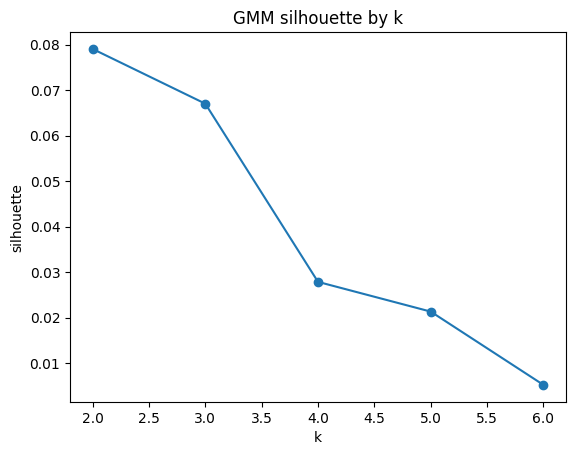


Chosen GMM k=2  (silhouette=0.128)


In [35]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# X = preprocessed matrix from earlier

df_cln_2 = df[~df[flag_cols].any(axis=1)].reset_index(drop=True)

X_pca = PCA(n_components=10, random_state=42).fit_transform(X)

k_vals, sil_scores = [], []
best_k, best_sil = None, -1
for k in range(2,7):
    gmm = GaussianMixture(k, random_state=42)
    labels = gmm.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    print(f'k={k}, silhouette={sil:.3f}')
    if sil > best_sil:
        best_k, best_sil, best_labels = k, sil, labels
    k_vals.append(k)
    sil_scores.append(silhouette_score(X, labels))

plt.plot(k_vals, sil_scores, marker='o')
plt.xlabel('k'); plt.ylabel('silhouette')
plt.title('GMM silhouette by k'); plt.show()

print(f"\nChosen GMM k={best_k}  (silhouette={best_sil:.3f})")
df_cln_2["cluster"] = best_labels

# ------------- save cluster-labelled dfs ----------
df_cln_1.to_csv("df_kmeans_clusters.csv", index=False)
df_cln_2.to_csv("df_gmm_clusters.csv", index=False)


I ran two clustering tricks:

1. K-Means (tried k = 2-8) → best silhouette ≈ 0.08 at k = 2.

2. PCA (10 dims) + Gaussian Mixture → best silhouette ≈ 0.13, also k = 2.

both methods agree on two broad clusters of almost equal size (~1.4 k rows each).

# **Segment analysis**


=== Cluster Kmeans Analysis ===

=== Numeric medians by cluster ===


,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours)
cluster,,,,
0,2020.0,52.31,488599.0,19.0
1,2020.0,49.26,512979.0,54.0


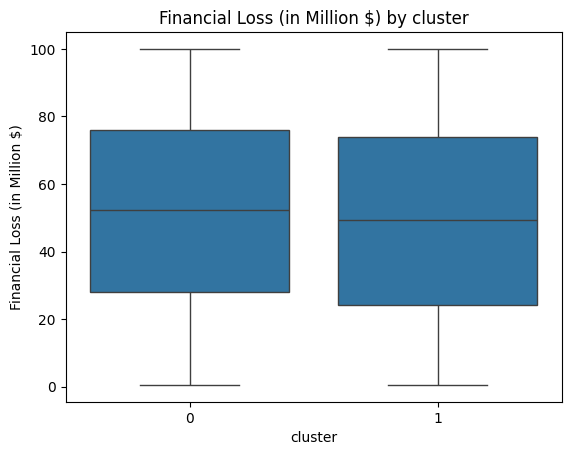

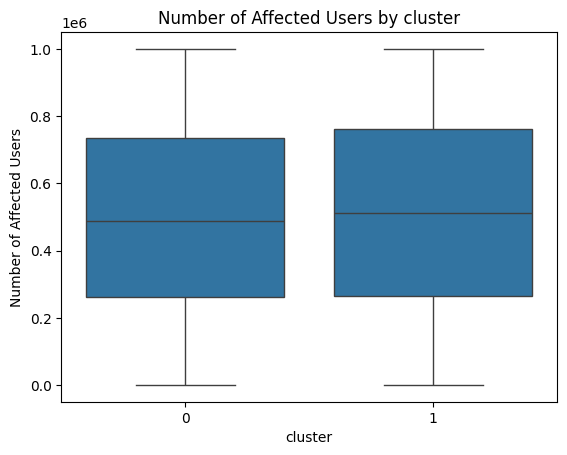

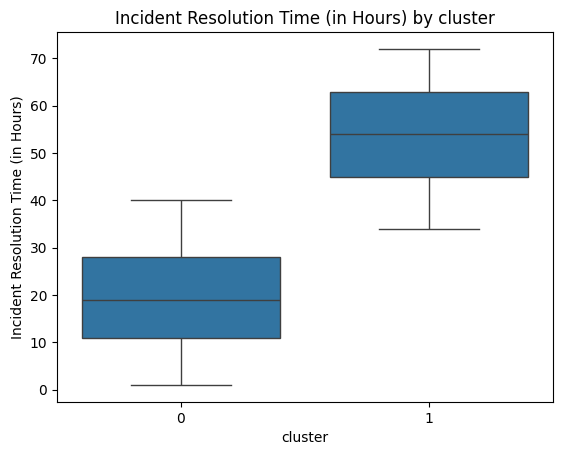


=== Country (% within cluster) ===


Country,Australia,Brazil,China,France,Germany,India,Japan,Russia,UK,USA
cluster,,,,,,,,,,
0,8.7,10.0,9.6,10.5,10.2,10.9,10.2,9.9,10.7,9.4
1,8.8,10.1,9.8,10.8,10.2,10.6,11.2,9.9,10.4,8.1



=== Attack Type (% within cluster) ===


Attack Type,DDoS,Malware,Man-in-the-Middle,Phishing,Ransomware,SQL Injection
cluster,,,,,,
0,16.9,16.2,16.2,19.0,15.9,15.9
1,15.8,16.4,16.0,17.7,17.4,16.7



=== Target Industry (% within cluster) ===


Target Industry,Banking,Education,Government,Healthcare,IT,Retail,Telecommunications
cluster,,,,,,,
0,14.8,14.2,13.5,15.0,16.9,14.0,11.6
1,13.2,14.3,14.4,14.5,15.9,14.9,12.8



=== Attack Source (% within cluster) ===


Attack Source,Hacker Group,Insider,Nation-state,Unknown
cluster,,,,
0,20.3,25.3,29.3,25.1
1,22.1,26.9,25.6,25.3



=== Security Vulnerability Type (% within cluster) ===


Security Vulnerability Type,Social Engineering,Unpatched Software,Weak Passwords,Zero-day
cluster,,,,
0,24.6,23.1,27.3,24.9
1,23.2,27.7,23.1,25.9



=== Defense Mechanism Used (% within cluster) ===


Defense Mechanism Used,AI-based Detection,Antivirus,Encryption,Firewall,VPN
cluster,,,,,
0,18.3,22.0,21.3,21.2,17.3
1,18.2,21.6,20.0,19.2,21.0


Country: p-value = 0.9873
Attack Type: p-value = 0.7739
Target Industry: p-value = 0.7399
Attack Source: p-value = 0.1508
Security Vulnerability Type: p-value = 0.0088
Defense Mechanism Used: p-value = 0.1255

=== Cluster GMM Analysis ===

=== Numeric medians by cluster ===


,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours)
cluster,,,,
0,2020.0,51.93,263668.0,36.0
1,2020.0,50.02,750875.0,37.0


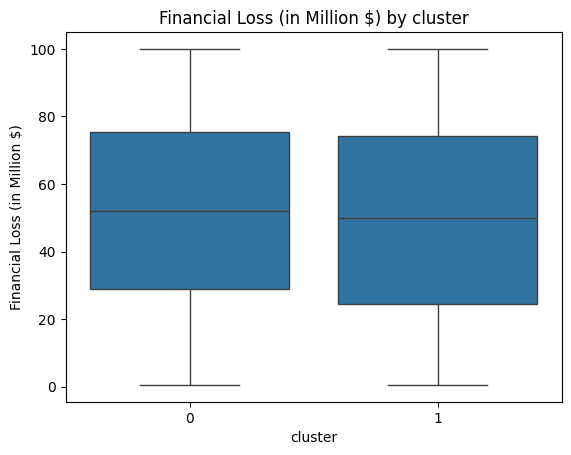

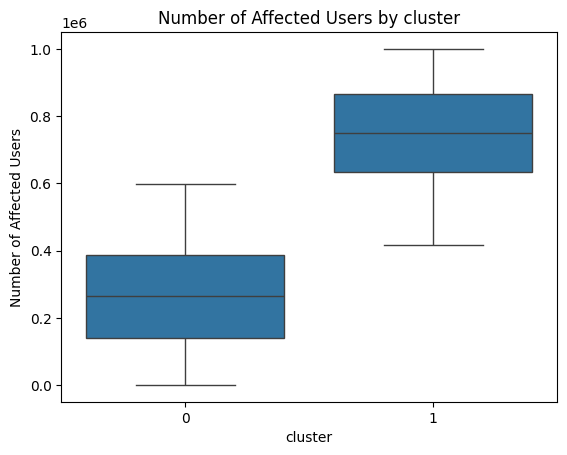

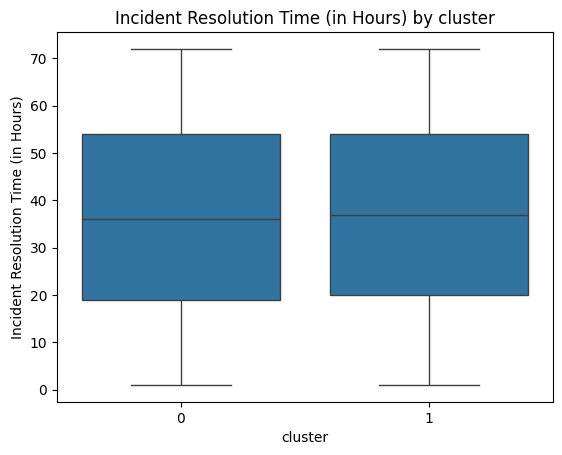


=== Country (% within cluster) ===


Country,Australia,Brazil,China,France,Germany,India,Japan,Russia,UK,USA
cluster,,,,,,,,,,
0,8.6,8.7,9.8,10.5,10.6,11.7,11.1,9.7,10.7,8.5
1,8.9,11.4,9.6,10.7,9.8,9.8,10.3,10.1,10.4,9.0



=== Attack Type (% within cluster) ===


Attack Type,DDoS,Malware,Man-in-the-Middle,Phishing,Ransomware,SQL Injection
cluster,,,,,,
0,16.5,16.2,15.1,19.4,16.6,16.1
1,16.2,16.4,17.0,17.2,16.7,16.5



=== Target Industry (% within cluster) ===


Target Industry,Banking,Education,Government,Healthcare,IT,Retail,Telecommunications
cluster,,,,,,,
0,13.6,13.4,14.3,14.7,15.1,15.1,13.8
1,14.4,15.2,13.6,14.9,17.8,13.7,10.5



=== Attack Source (% within cluster) ===


Attack Source,Hacker Group,Insider,Nation-state,Unknown
cluster,,,,
0,19.3,24.0,29.5,27.2
1,23.1,28.4,25.5,23.1



=== Security Vulnerability Type (% within cluster) ===


Security Vulnerability Type,Social Engineering,Unpatched Software,Weak Passwords,Zero-day
cluster,,,,
0,24.8,28.3,22.3,24.7
1,23.1,22.5,28.3,26.2



=== Defense Mechanism Used (% within cluster) ===


Defense Mechanism Used,AI-based Detection,Antivirus,Encryption,Firewall,VPN
cluster,,,,,
0,18.3,21.8,21.1,19.7,19.1
1,18.1,21.9,20.2,20.7,19.1


Country: p-value = 0.4963
Attack Type: p-value = 0.6098
Target Industry: p-value = 0.0553
Attack Source: p-value = 0.0004
Security Vulnerability Type: p-value = 0.0001
Defense Mechanism Used: p-value = 0.9574


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def Print_Cluster(df_cln):
    # df_cln already has 'cluster' from Step 6
    # Split numeric & categorical cols (drop helper flags)
    num_cols = [c for c in df_cln.select_dtypes('number').columns if c != 'cluster']
    cat_cols = [c for c in df_cln.select_dtypes('object').columns]

    # ---------- A. Numeric summaries ----------
    print("\n=== Numeric medians by cluster ===")
    display(df_cln.groupby('cluster')[num_cols].median().round(2).sort_index())

    # Box-plots for key numerics
    for col in ['Financial Loss (in Million $)', 
                'Number of Affected Users', 
                'Incident Resolution Time (in Hours)']:
        sns.boxplot(data=df_cln, x='cluster', y=col)
        plt.title(f'{col} by cluster'); plt.show()

    # ---------- B. Categorical frequency tables ----------
    for col in cat_cols:
        tab = (df_cln.groupby('cluster')[col]
                    .value_counts(normalize=True)
                    .rename('pct')
                    .mul(100)
                    .round(1)
                    .unstack(fill_value=0))
        print(f"\n=== {col} (% within cluster) ===")
        display(tab.iloc[:10])          # .head() keeps it short; drop if you want full table
    
        # # stacked bar
        # tab.T.plot(kind='bar', stacked=True, figsize=(6,3))
        # plt.title(f'{col} distribution by cluster')
        # plt.ylabel('%'); plt.legend(title='cluster'); plt.tight_layout(); plt.show()

    # Optional: chi-square test to see if distribution differs
    from scipy.stats import chi2_contingency
    for col in cat_cols:
        cont = pd.crosstab(df_cln['cluster'], df_cln[col])
        chi2, p, *_ = chi2_contingency(cont)
        print(f"{col}: p-value = {p:.4f}")


print("\n=== Cluster Kmeans Analysis ===")

Print_Cluster(df_cln_1)
print("\n=== Cluster GMM Analysis ===")

Print_Cluster(df_cln_2)

conclusion:

from Kmeans (k = 2) we got that the dataset can be separated using the feature Incident Resolution Time (cluster 0 = 19 hours, cluster 1 = 54 hours).
in others words attacks that were fast and slow to resolve, thats why we can see in cluster 0 more basic attacks like phishing and used vulnerability like weak passwords and in cluster 1 we can see they used attacks that are harder to resolve like SQL interjection (my guess is its harder to debug and find the problem) and thats why it takes longer.

The GMM model(k = 2)  we got that the dataset can be separated using the feature Number Of Affected Users (cluster 0 = 263K, cluster 1 = 750K).
here we can see in cluster 0 most events trace back to nation-state or unknown actors exploiting unpatched software and because these are precision breaches, the attackers grabe what they came for and leave, and thats why the Number of Affected Users is lower but i cluster 1 we see the trigger is weak passwords and insider/hacker-group activity and once the info starts spreading inside a company, the damage grows quickly and thats why the Number of Affected Users is higher.


# **NLP**

The columns in the dataset use set categories instead of open text, so there is no need to use traditional NLP techniques because it wont add any value

# **Graphs**

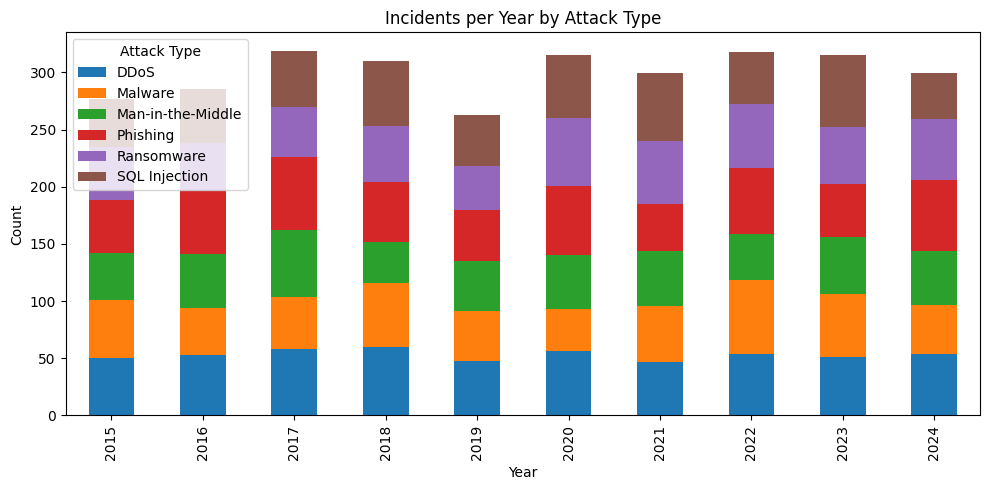

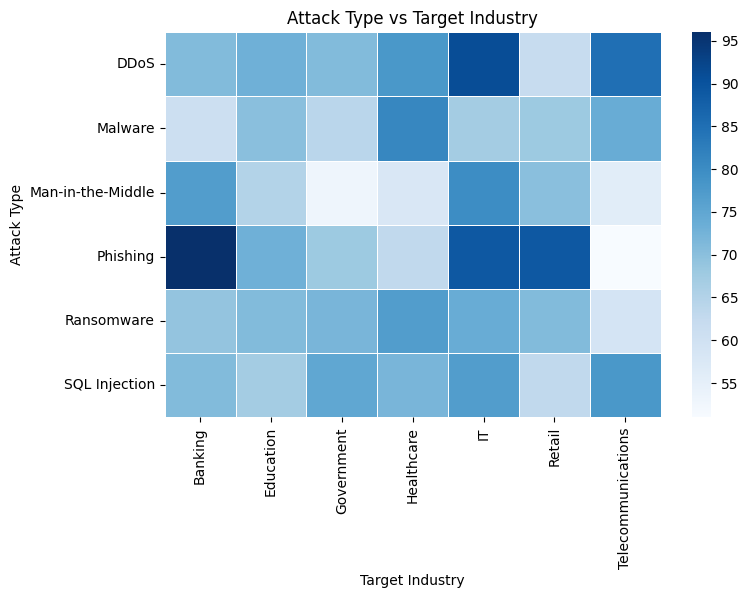

In [63]:
# %pip install networkx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# ------------------------------------------------------------------
# Load the clean, cluster-labelled dataframe (no outliers)
# ------------------------------------------------------------------
df_vis = pd.read_csv("dataset_with_all_outlier_flags.csv")   # or df_kmeans_clusters.csv

# ------------------------------------------------------------------
# 1. Annual attack mix (stacked bar)
# ------------------------------------------------------------------
plt.figure(figsize=(10,5))
mix = (df_vis.groupby(['Year','Attack Type'])
              .size()
              .unstack(fill_value=0)
              .sort_index())
mix.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Incidents per Year by Attack Type')
plt.ylabel('Count'); plt.tight_layout(); plt.show()

# ------------------------------------------------------------------
# 2. Heat-map: Attack Type × Target Industry
# ------------------------------------------------------------------
plt.figure(figsize=(8,5))
heat = (df_vis.groupby(['Attack Type','Target Industry'])
               .size()
               .unstack(fill_value=0))
sns.heatmap(heat, cmap='Blues', linewidths=.5, annot=False)
plt.title('Attack Type vs Target Industry'); plt.show()



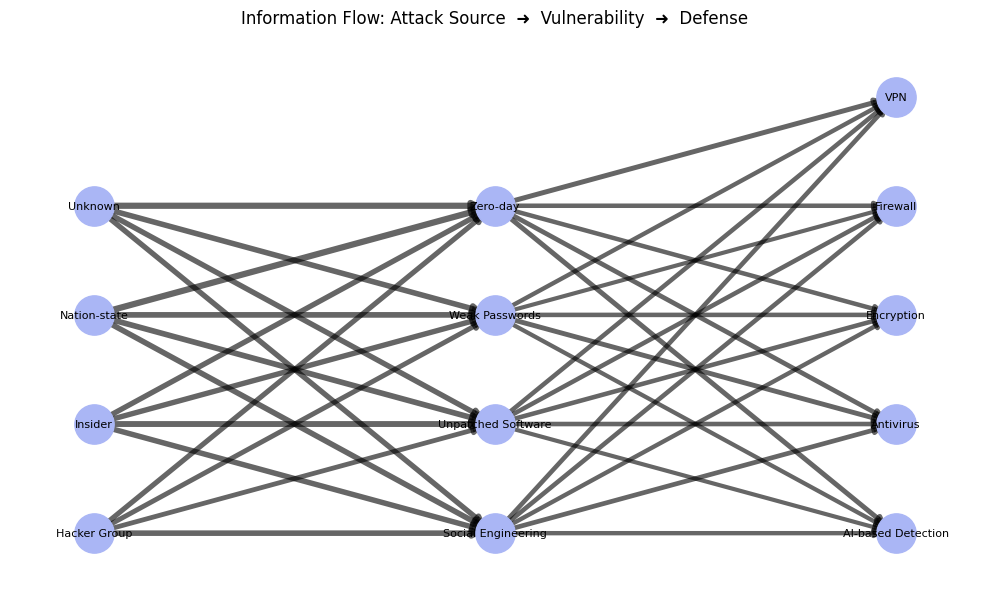

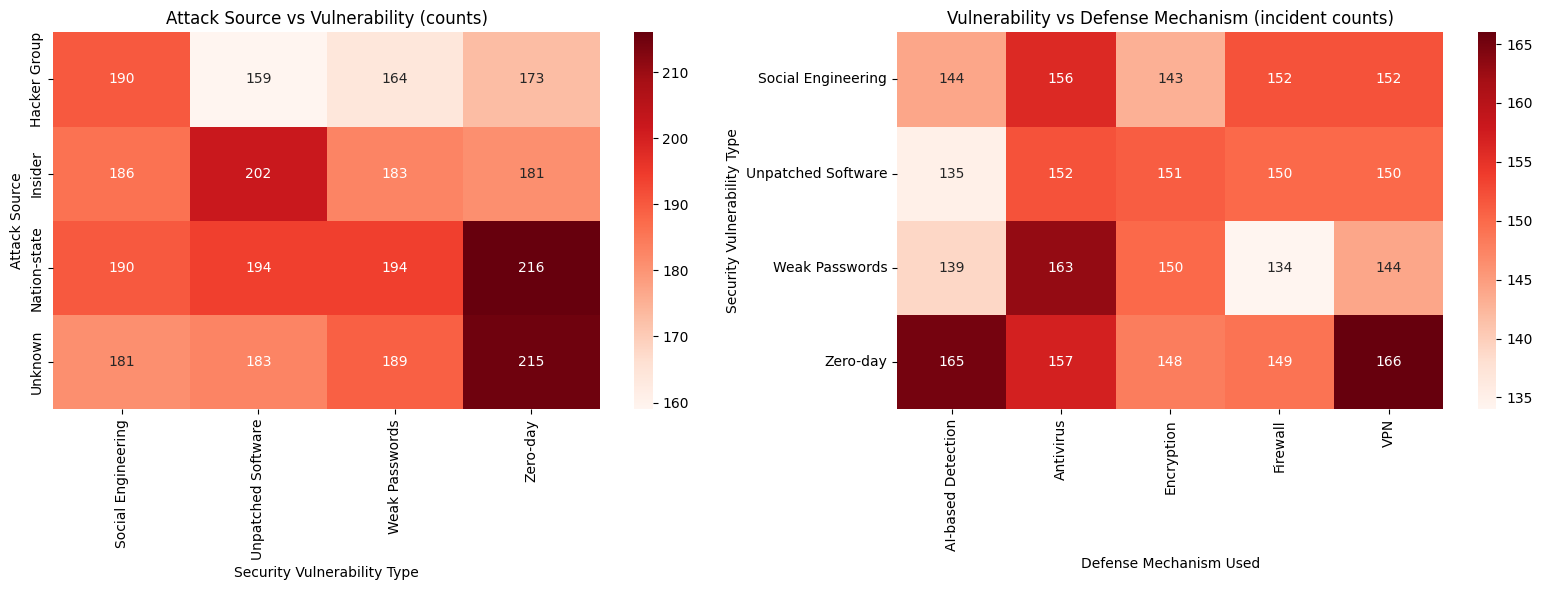

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ---------------- load your dataframe ----------------
df_flow = pd.read_csv("dataset_with_all_outlier_flags.csv")          # or df_kmeans_clusters.csv

# ---------------- build edge list --------------------
edges = []
for _, r in df_flow.iterrows():
    edges.append((r['Attack Source'], r['Security Vulnerability Type']))
    edges.append((r['Security Vulnerability Type'], r['Defense Mechanism Used']))

edge_df = (pd.DataFrame(edges, columns=['src','dst'])
             .value_counts()
             .reset_index(name='weight'))

# ---------------- construct directed graph -----------
G = nx.DiGraph()
for _, row in edge_df.iterrows():
    G.add_edge(row['src'], row['dst'], weight=row['weight'])

# ---------------- layer the nodes --------------------
left   = sorted(df_flow['Attack Source'].unique())
middle = sorted(df_flow['Security Vulnerability Type'].unique())
right  = sorted(df_flow['Defense Mechanism Used'].unique())

pos = {}
y_spacing = 1.5
for i, node in enumerate(left):
    pos[node]   = (0,  i * y_spacing)
for i, node in enumerate(middle):
    pos[node]   = (5,  i * y_spacing)
for i, node in enumerate(right):
    pos[node]   = (10, i * y_spacing)

# ---------------- draw -------------------------------
plt.figure(figsize=(10, 6))
max_w = max(nx.get_edge_attributes(G, 'weight').values())
weights = [G[u][v]['weight']/max_w * 4 + 0.5  # 0.5–4.5 px
           for u, v in G.edges()]

# min_w = min(nx.get_edge_attributes(G, 'weight').values())
# weights = [(G[u][v]['weight']-min_w + 1)*0.1  # 0.5–4.5 px
#            for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#AAB6F5")
nx.draw_networkx_labels(G, pos, font_size=8)

nx.draw_networkx_edges(G, pos,
                       width=weights,
                       arrows=True, arrowstyle='-|>', alpha=0.6)

plt.title("Information Flow: Attack Source  ➜  Vulnerability  ➜  Defense",
          fontsize=12, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Attack Source vs Vulnerability heatmap
atk_tbl = (df_flow.groupby(['Attack Source', 'Security Vulnerability Type'])
                 .size()
                 .unstack(fill_value=0))

# Vulnerability vs Defense Mechanism heatmap
vuln_def_tbl = (df_flow.groupby(['Security Vulnerability Type', 'Defense Mechanism Used'])
                        .size()
                        .unstack(fill_value=0))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(atk_tbl, cmap='Reds', annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Attack Source vs Vulnerability (counts)')
axes[0].set_xlabel('Security Vulnerability Type')
axes[0].set_ylabel('Attack Source')

sns.heatmap(vuln_def_tbl, cmap='Reds', annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Vulnerability vs Defense Mechanism (incident counts)')
axes[1].set_xlabel('Defense Mechanism Used')
axes[1].set_ylabel('Security Vulnerability Type')

plt.tight_layout()
plt.show()








*graphs about the clusters were added in the segment area.